In [946]:
from sensible_raw.loaders import loader
import numpy as np
from __future__ import division
import mpmath as mp
import json
import pandas as pd
from mpl_toolkits.basemap import Basemap

from geopy.distance import great_circle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bisect import *
from collections import Counter
import calmap
plt.rcParams['figure.figsize'] = (10, 4)

In [947]:
#Creating a list containing the months which fits the input of "load_data_all_months_all_month".
def load_date(start_date,end_date):
    date_list = []
    month = ['january','february','march','april','may','june','july','august','september','october','november','december']
    temp_year = start_date[1]
    temp_month = start_date[0]
    while temp_year<=end_date[1]:
        if temp_year<end_date[1]:
            upper_month=12
        else:
            upper_month=end_date[0]
        while temp_month<=upper_month:
            date_list.append(str(month[temp_month-1])+'_'+str(temp_year))
            temp_month+=1
        temp_year+=1
        temp_month=1
    return date_list
            

In [948]:
#Input:  A  list with the months we want to look at
#Output:  A pandas dataframe with all the data
def load_data_all_months(months,data_type):
    boo = True
    for i in months:
        columns, data = loader.load_data(data_type,i)
        if boo:
            dict = {}
            for column, array in zip(columns, data):
                dict[column] = array
            boo = False
        else:
            for column, array in zip(columns, data):
                dict[column]=np.ma.append(dict[column],array)
    dataframe = pd.DataFrame(dict)
    return dataframe

In [949]:
#Making a sequence for each user
#Input: dataframe
#Output: A list of sequences for each user
def make_seq(dataframe, data_type):
    seq = {}
    if data_type == 'stop_locations':
        for i in set(dataframe['user']):
            seq[i]=[dataframe.loc[dataframe['user'].isin([i])]['label']][0].tolist()
    elif data_type == 'cell':
        for i in set(dataframe['user']):
            cid=[dataframe.loc[dataframe['user'].isin([i])]['cid']][0].tolist()
            lac=[dataframe.loc[dataframe['user'].isin([i])]['lac']][0].tolist()
            seq[i]=[float(str(int(x[0]))+'.'+str(int(x[1]))) for x in zip(cid,lac)]
    return seq

In [950]:
#Editing our sequence. Making AAABBBCCCDD = ABCD and also removing all users who has less than a certain number N places
#Input:
#      seq: A list constaining lists of each user
#        N: An integer for the minimum of different locations visited after
def location_seq(seq,N=0):
    for i in seq.keys():
        j=1
        while j<len(seq[i]):
            if seq[i][j]==seq[i][j-1]:
                del seq[i][j]
            else:
                j+=1
    for i in seq.keys():
        if len(seq[i])<=N:
            del seq[i]
    return seq

In [951]:
# State entropy (only num of states)
# S^{rand} = log2(N), N = 'number of states'
def func_S_rand(seq):
    return np.log2(len(np.unique(seq)))

In [952]:
# Distribution entropy (uncorrelaed)
# S^{unc} = - sum_{i=1..n}(p_i * log2(p_i))
# Where p_i is the probability for state i.
# The sum of all probabilitys is 1: sum_{i=1..n}(p_i) = 1
def func_S_unc(seq):
    
    n = float(len(seq))
    states = np.unique(seq)
    N_states = len(np.unique(states))
    
    p = np.zeros(N_states)
    for i in range(N_states):
        p[i] = seq.count(states[i])/n
    
    return sum(-p * np.log2(p))

In [953]:
# Lambda function for True entropy:
# Taken from Matlab function!
def func_Lambda(seq, i):
    n = len(seq)
    
    # Insert terminal symbol
    seq = seq + [min(seq)-1]
    
    x = 1
    mps = [idx for (idx, val) in enumerate(seq[:i]) if val == seq[i]]
    while (mps and x <= n-i):
        if mps[-1] + x >= i:
            del mps[-1]
            
        mps = [idx for idx in mps if seq[idx+x] == seq[i+x]]
        x += 1
        
    return x

In [954]:
# True entropy: Distribution entropy (correlaed), looks at correlations in the sequens
# S = - sum_{T'_i in T_i}(P(T'_i) * log2(P(T'_i)))
def func_S(seq):
    
    n = len(seq)
    L = np.zeros(n)
    
    for i in range(n):
        # Lambda function call
        L[i] = func_Lambda(seq,i)
    
    # Function from Gavin Smith (LoPpercom)
    # S = np.power(sum([L[i] / np.log2(i+1) for i in range(1,n)] ) * (1.0/n),-1)
    # Function from Morten Proschowsky (Matlab)
    S = n/sum(L) * np.log2(n)
    return S

In [955]:
# Predictability solving: 
# solve(0 = [-x*log2(x)-(1-x)*log2(1-x)+(1-x)*log2(N-1)] - S
# Returns value between 0 and 1.
def func_Pred(S_score,N_states):
    
    if N_states <= 1:
        return 1
    
    # Convex function for the predictibility bound
    func = lambda x, S, N: (-(x*mp.log(x,2)+(1-x)*mp.log(1-x,2))+(1-x)*mp.log(N-1,2))-S
    func2 = lambda x: func(x,S_score,N_states)
    # Solve function f(x) = 0
    res = mp.findroot(func2,0.95).real
    
    return float(res)

In [956]:
# Returns S_rand, S_unc, S, U_rand, U_unc and U_max.
# Set print_res to True to print results
def Compute_all(seq, print_res = False):
    N_states = len(np.unique(seq))
    S_rand = func_S_rand(seq)
    S_unc  = func_S_unc(seq)
    S = func_S(seq)
    U_rand = func_Pred(S_rand,N_states)
    U_unc  = func_Pred(S_unc,N_states)
    U_max  = func_Pred(S,N_states)
    
    if print_res:
        print 'S_rand: ' + str(S_rand)
        print 'S_unc:  ' + str(S_unc)
        print 'S:      ' + str(S)
        print 'U_rand: ' + str(U_rand)
        print 'U_unc:  ' + str(U_unc)
        print 'U_max:  ' + str(U_max)
        
    return (S_rand, S_unc, S, U_rand, U_unc, U_max)

In [957]:
#Computes the entropy for a sequence given for each length in the input lists.
def entropy_convergence(seq, lists):
    seq_entropy = {}
    for i in seq.keys():
        seq_entropy[i]=[]
    for i in lists:
        seq_temp = location_seq(seq,i)
        for key in seq_temp.keys():
            seq_entropy[key].append(func_S(seq[key][:i]))
    return seq_entropy

In [958]:
#Makes a heat  map
def calmap_plot(df,time_type,vmin=None, vmax = None):
    Dates = pd.to_datetime(df['timestamp'],unit = time_type)
    df_heat = pd.Series([1 for i in range(df.shape[0])],index = Dates)
    f,ax = calmap.calendarplot(df_heat,fillcolor=(0,0,0.5),cmap='gist_heat_r',vmin=vmin,vmax=vmax)

In [959]:
#initializing the data
df_phone = load_data_all_months(load_date([3,2014],[2,2015]),'calllog')
df_sms = load_data_all_months(load_date([3,2014],[2,2015]),'sms')
df_cell = load_data_all_months(load_date([3,2014],[2,2015]),'cell')
df_cell = df_cell.sort_values(by=['timestamp'])[df_cell['cid']!=-1][df_cell['lac']!=-1]
df_use = pd.concat([df_phone[['timestamp','user']],df_sms[['timestamp','user']]])
df_use = df_use.sort_values(by=['timestamp'])

In [960]:
#Creating a dictionary containing the every user, and its sequence from the pandas input
#It also checks the mobile data with the cell tower data and fetches all info of cid and lac.
usage_dict = {}
usage_count = {}
for user in df_use['user'].unique():
    count = 0
    df_use_temp = df_use[df_use['user']==user]['timestamp'].tolist()
    df_cell_temp = df_cell[df_cell['user']==user]
    if df_cell_temp.size==0:
        continue
    usage_dict[user]=[]
    indexes = df_cell_temp['timestamp'].searchsorted(df_use_temp)
    max_index = df_cell_temp.shape[0]
    for index in range(len(indexes)):
        if indexes[index]>max_index-1:
            continue
        if abs(df_use_temp[index]-df_cell_temp['timestamp'].iloc[indexes[index]])<3600000: #Checking if the distance is greater than an hour
            nearest_loc = df_cell_temp.iloc[indexes[index]]
            usage_dict[user].append(int(nearest_loc['lac']))
        else:
            count+=1
    if usage_dict[user]==[]:
        usage_dict.pop(user,None)
    else:
        usage_count[user]=count

    

In [961]:
#Check the amount of complete weeks for each user
complete_data = {}
for user in set(df_use['user']):
    complete_data[user]=[]
    df_use_temp = df_use[df_use['user']==user]
    time = df_use_temp.iloc[0]['timestamp']/1000  #start time
    time_day = 86400
    while time < df_use_temp.iloc[-1]['timestamp']/1000:
        count = 0
        for day in range(7):
            if df_use_temp[(df_use_temp['timestamp']/1000>=time) & (df_use_temp['timestamp']/1000<time+time_day)].size!=0:
                count+=1
            time +=time_day
        if count>=1:
            complete_data[user].append(1)
        else:
            complete_data[user].append(0) 

In [962]:
# Saves all users which satisfies our requirements
best_users = []
for key in usage_dict.keys():
    if len(complete_data[key])>=50 and sum(complete_data[key])/len(complete_data[key])>=0.85 and usage_count[key]/(usage_count[key]+len(usage_dict[key]))<=0.1:
        best_users.append([key,len(usage_dict[key])])

In [963]:
# Making the sequences location based, i.e. aaabbbccc -> abc
usage_dict = location_seq(usage_dict)

In [964]:
# Making a new sequence containing only the best users fround ealier
seq_best = {}
for i in best_users:
    seq_best[i[0]]=usage_dict[i[0]]

In [965]:
# Creating a list of sequence lengths of the full data
data_points = []
for user_seq in usage_dict.values():
    data_points.append(len(user_seq))

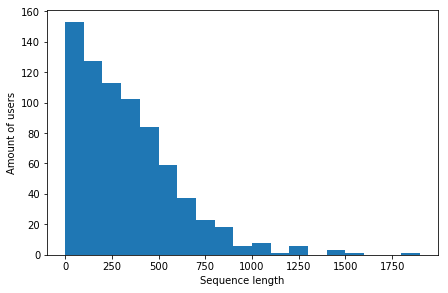

In [966]:
# Plotting the lengths
plt.figure(figsize=(7,4.5))
plt.hist(data_points,range(0,max(data_points)+100,100))
plt.xlabel("Sequence length")
plt.ylabel("Amount of users")

In [967]:
# Creating a list of sequence lengths of the best data
data_points_compl = []
for user_seq in seq_best.values():
    data_points_compl.append(len(user_seq))

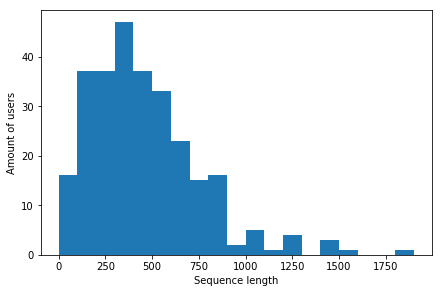

In [968]:
# Plotting the lengths
plt.figure(figsize=(7,4.5))
plt.hist(data_points_compl,range(0,max(data_points_compl)+100,100))
plt.xlabel("Sequence length")
plt.ylabel("Amount of users")

In [969]:
#Computing the different entropies and predictabilities for each user of the full data set
S_rand_all, S_unc_all, S_all, U_rand_all, U_unc_all, U_max_all=[],[],[],[],[],[]
for seq in usage_dict.values():
    S_rand, S_unc, S, U_rand, U_unc, U_max = Compute_all(seq)
    S_rand_all.append(S_rand)
    S_unc_all.append(S_unc)
    S_all.append(S)
    U_rand_all.append(U_rand)
    U_unc_all.append(U_unc)
    U_max_all.append(U_max)

<function matplotlib.pyplot.show>

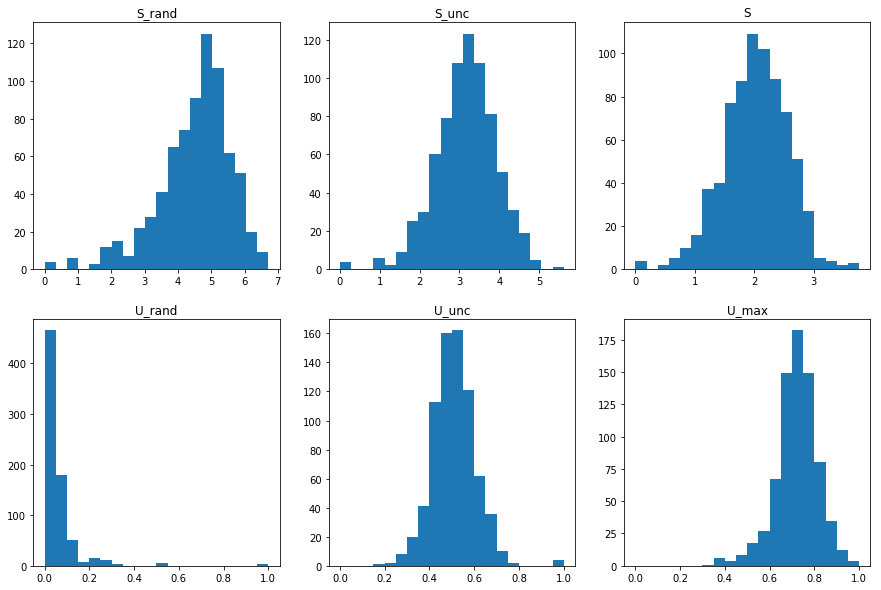

In [970]:
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.hist(S_rand_all,20)
plt.title('S_rand')

plt.subplot(232)
plt.hist(S_unc_all,20)
plt.title('S_unc')

plt.subplot(233)
plt.hist(S_all,20)
plt.title('S')

plt.subplot(234)
plt.hist(U_rand_all,20,range=(0,1))
plt.title('U_rand')

plt.subplot(235)
plt.hist(U_unc_all,20,range=(0,1))
plt.title('U_unc')

plt.subplot(236)
plt.hist(U_max_all,20,range=(0,1))
plt.title('U_max')

plt.show



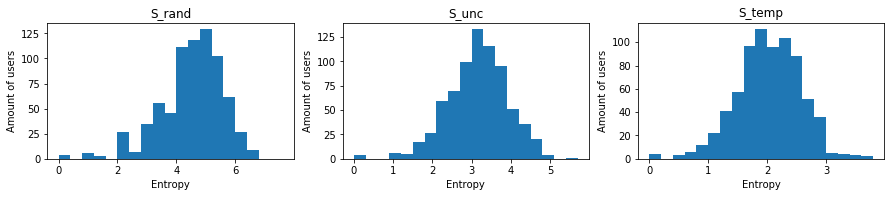

In [971]:
plt.figure(figsize=(15,2.5))

plt.subplot(131)
plt.hist(S_rand_all,np.arange(0,8,8/20))
plt.title('S_rand')
plt.ylabel('Amount of users')
plt.xlabel("Entropy")

plt.subplot(132)
plt.hist(S_unc_all,np.arange(0,6,6/20))
plt.title('S_unc')
plt.xlabel("Entropy")
plt.ylabel('Amount of users')

plt.subplot(133)
plt.hist(S_all,np.arange(0,4,4/20))
plt.title('S_temp')
plt.xlabel("Entropy")
plt.ylabel('Amount of users')

In [972]:
#Computing the different entropies and predictabilities for each user of the best data
S_rand_all, S_unc_all, S_all, U_rand_all, U_unc_all, U_max_all=[],[],[],[],[],[]
for seq in seq_best.values():
    S_rand, S_unc, S, U_rand, U_unc, U_max = Compute_all(seq)
    S_rand_all.append(S_rand)
    S_unc_all.append(S_unc)
    S_all.append(S)
    U_rand_all.append(U_rand)
    U_unc_all.append(U_unc)
    U_max_all.append(U_max)

<function matplotlib.pyplot.show>

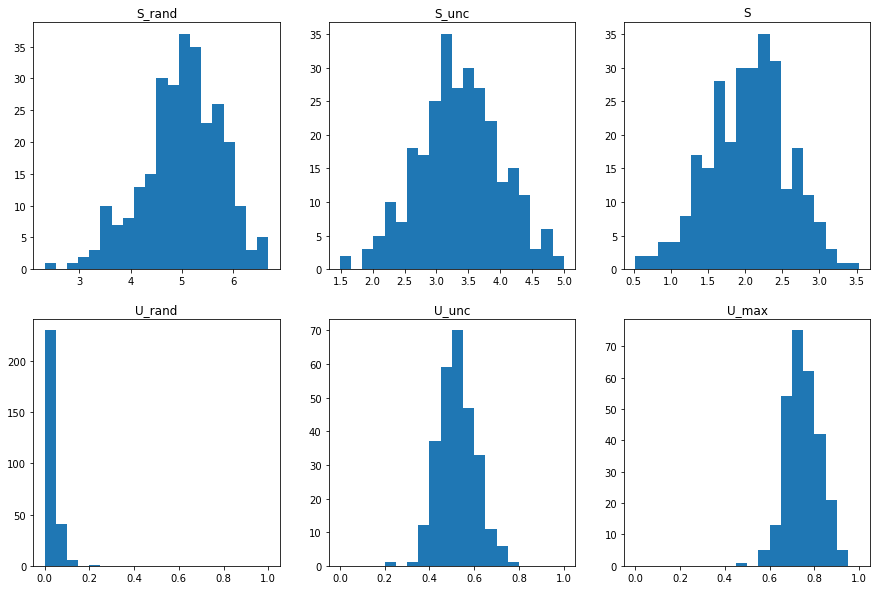

In [973]:
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.hist(S_rand_all,20)
plt.title('S_rand')

plt.subplot(232)
plt.hist(S_unc_all,20)
plt.title('S_unc')

plt.subplot(233)
plt.hist(S_all,20)
plt.title('S')

plt.subplot(234)
plt.hist(U_rand_all,20,range=(0,1))
plt.title('U_rand')

plt.subplot(235)
plt.hist(U_unc_all,20,range=(0,1))
plt.title('U_unc')

plt.subplot(236)
plt.hist(U_max_all,20,range=(0,1))
plt.title('U_max')

plt.show



# Convergence


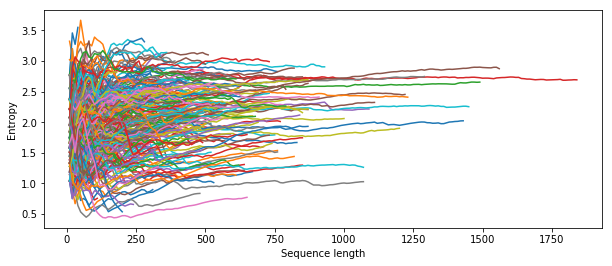

In [974]:
# Plotting the entropy convergence
Curves = []
Curves_index = []
for i in range(len(seq_best.keys())):
    index = seq_best.keys()[i]
    a = entropy_convergence({index:seq_best[index]},range(10,5000,10))[index]
    Curves.append(a)  
    Curves_index.append(index)
    #plt.plot(range(10,3000,10)[:len(a)],a,label = 'User '+ str(index))
    plt.plot(range(10,5000,10)[:len(a)],a)
    plt.legend()
    plt.xlabel("Sequence length")
    plt.ylabel("Entropy")

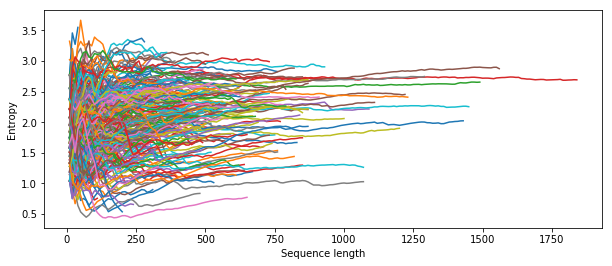

In [975]:
# With labels
for i in Curves:
    plt.plot(range(10,5000,10)[:len(i)],i)
    plt.legend()
    plt.xlabel("Sequence length")
    plt.ylabel("Entropy")

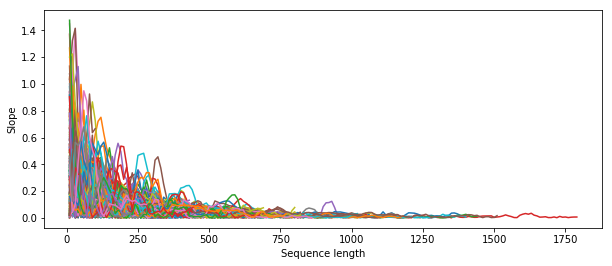

In [976]:
# Plotting the slope of the convergence
for i in range(len(Curves)):
    curve = [abs(Curves[i][j]-Curves[i][j+5]) for j in range(len(Curves[i])-5)]
    plt.plot(range(10,5000,10)[:len(curve)],curve)
    plt.xlabel("Sequence length")
    plt.ylabel("Slope")

In [977]:
# Checking if the convergence satisfies our requirements
count = 0
count_best_users = []
for i in range(len(seq_best.keys())):
    curve = [abs(Curves[i][j]-Curves[i][j+5]) for j in range(len(Curves[i])-5)]
    for j in range(len(curve)-10):
        if sorted(curve[j:j+10])[-3]<0.05:
            count+=1
            count_best_users.append(Curves_index[i])
            break

In [978]:
# Saving the new best users which satisfies the estimator convergence
seq_best_final = {}
for user in count_best_users:
    seq_best_final[user] = seq_best[user]

In [979]:
# Making a pandas dataframe to save best users
df_user_entropy = 0
df_user_entropy = pd.DataFrame(columns=('user','S_ran','S_unc','S_temp','Length','unique'))
index=0
for user in seq_best_final.keys():
    seq = seq_best[user]
    seq_len = len(seq)
    S_rand = func_S_rand(seq)
    S_unc  = func_S_unc(seq)
    S = func_S(seq)
    unique = len(np.unique(seq)) 
    df_user_entropy.loc[index]=[int(user),S_rand,S_unc,S,seq_len,unique]
    index+=1

In [980]:
# Saving the best users
df_user_entropy.to_csv('best_users_sms_entropy.csv')

In [981]:
# Computing entropy and predictability for the new best users
S_rand_all, S_unc_all, S_all, U_rand_all, U_unc_all, U_max_all=[],[],[],[],[],[]
for seq in seq_best_final.values():
    S_rand, S_unc, S, U_rand, U_unc, U_max = Compute_all(seq)
    S_rand_all.append(S_rand)
    S_unc_all.append(S_unc)
    S_all.append(S)
    U_rand_all.append(U_rand)
    U_unc_all.append(U_unc)
    U_max_all.append(U_max)

<function matplotlib.pyplot.show>

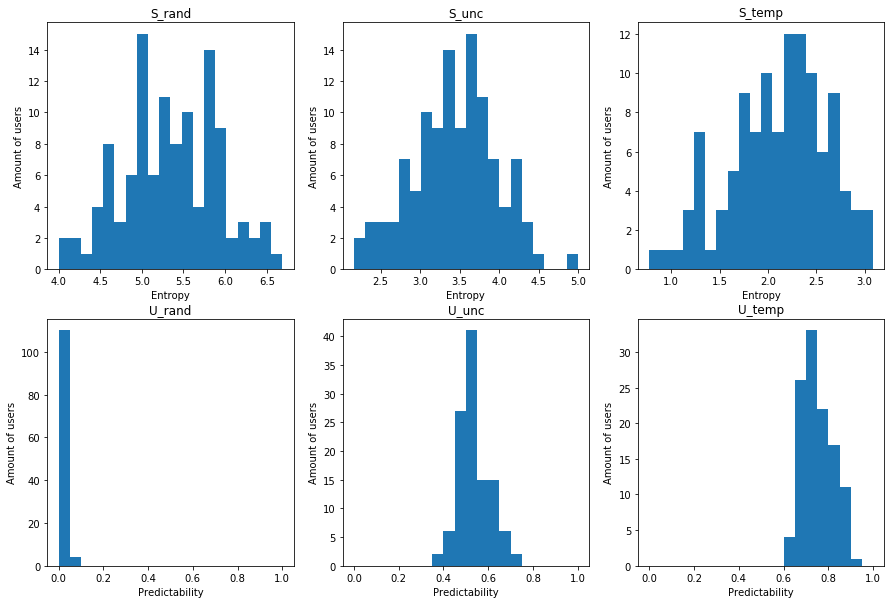

In [982]:
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.hist(S_rand_all,20)
plt.title('S_rand')
plt.ylabel('Amount of users')
plt.xlabel("Entropy")

plt.subplot(232)
plt.hist(S_unc_all,20)
plt.title('S_unc')
plt.xlabel("Entropy")
plt.ylabel('Amount of users')

plt.subplot(233)
plt.hist(S_all,20)
plt.title('S_temp')
plt.xlabel("Entropy")
plt.ylabel('Amount of users')

plt.subplot(234)
plt.hist(U_rand_all,20,range=(0,1))
plt.title('U_rand')
plt.ylabel('Amount of users')
plt.xlabel("Predictability")

plt.subplot(235)
plt.hist(U_unc_all,20,range=(0,1))
plt.title('U_unc')
plt.xlabel("Predictability")
plt.ylabel('Amount of users')

plt.subplot(236)
plt.hist(U_max_all,20,range=(0,1))
plt.title('U_temp')
plt.xlabel("Predictability")
plt.ylabel('Amount of users')

plt.show

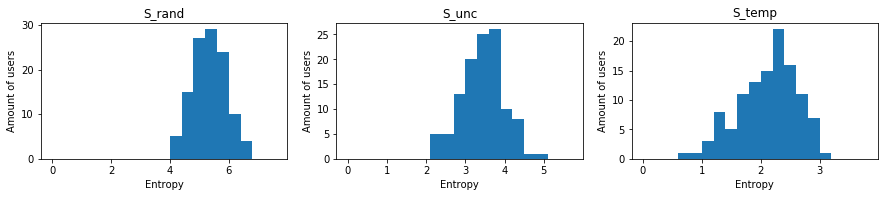

In [983]:
plt.figure(figsize=(15,2.5))

plt.subplot(131)
plt.hist(S_rand_all,np.arange(0,8,8/20))
plt.title('S_rand')
plt.ylabel('Amount of users')
plt.xlabel("Entropy")

plt.subplot(132)
plt.hist(S_unc_all,np.arange(0,6,6/20))
plt.title('S_unc')
plt.xlabel("Entropy")
plt.ylabel('Amount of users')

plt.subplot(133)
plt.hist(S_all,np.arange(0,4,4/20))
plt.title('S_temp')
plt.xlabel("Entropy")
plt.ylabel('Amount of users')

<function matplotlib.pyplot.show>

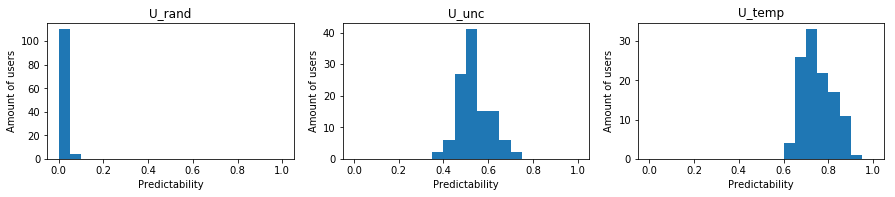

In [984]:
plt.figure(figsize=(15,2.5))

plt.subplot(131)
plt.hist(U_rand_all,20,range=(0,1))
plt.title('U_rand')
plt.ylabel('Amount of users')
plt.xlabel("Predictability")

plt.subplot(132)
plt.hist(U_unc_all,20,range=(0,1))
plt.title('U_unc')
plt.xlabel("Predictability")
plt.ylabel('Amount of users')

plt.subplot(133)
plt.hist(U_max_all,20,range=(0,1))
plt.title('U_temp')
plt.xlabel("Predictability")
plt.ylabel('Amount of users')

plt.show

# Gap sizes

In [985]:
# Finding the sizes of the gaps in the full data
gaps = []
for user in df_use['user'].unique():
    df_use_temp = df_use[df_use['user']==user]
    gaps.extend(df_use_temp['timestamp'].diff().tolist()[1:])

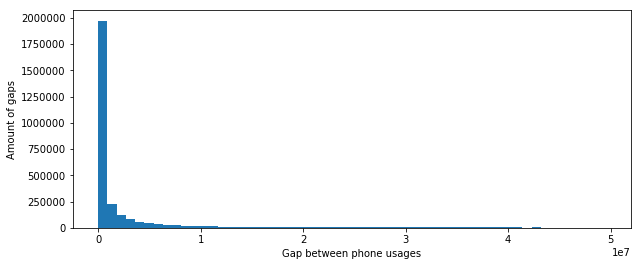

In [986]:
#Plotting the gap sizes
a,b,c = plt.hist(gaps,range(0,50000000,900000)) #For hvert kvarter
plt.xlabel("Gap between phone usages")
plt.ylabel("Amount of gaps")

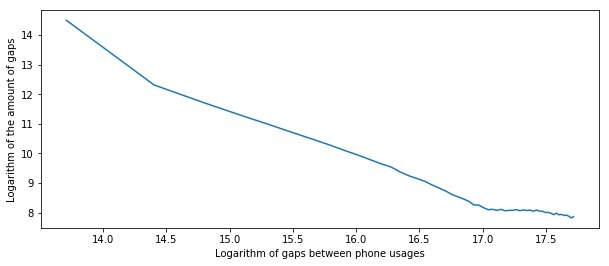

In [987]:
# Plotting the log log of the gap sizes
plt.plot(np.log(b[1:]),np.log(a))
plt.xlabel("Logarithm of gaps between phone usages")
plt.ylabel("Logarithm of the amount of gaps")

# Heat Maps

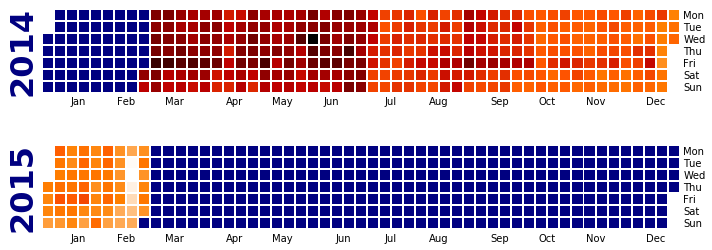

In [988]:
#Full data
calmap_plot(df_use,'ms')

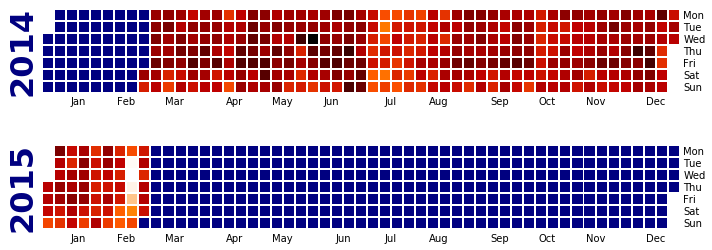

In [989]:
#Some of the best users
calmap_plot(df_use[df_use['user'].isin(seq_best_final.keys())],'ms')

# Getting user location for map plot

In [990]:
#Import the cell locations
dataframe_cells = pd.read_csv('cell_towers_DK_stor.csv')   #For mylnikov.org/archives/1059
cell_dict_DK = {}
for coloums, row in dataframe_cells.iterrows():
    net,area, cell, lon, lat = row[5],row[6],row[7],row[9],row[8]    #mylnikov
    if area in cell_dict_DK:
        if cell in cell_dict_DK[area]:
            cell_dict_DK[area][cell].append([lat,lon])
        else:
            cell_dict_DK[area][cell]=[[lat,lon]]
    else:
        cell_dict_DK[area]={cell:[[lat,lon]]}

In [991]:
#Getting the data we want to look at
df_loc_heat = load_data_all_months(load_date([4,2014],[4,2014]),'stop_locations')

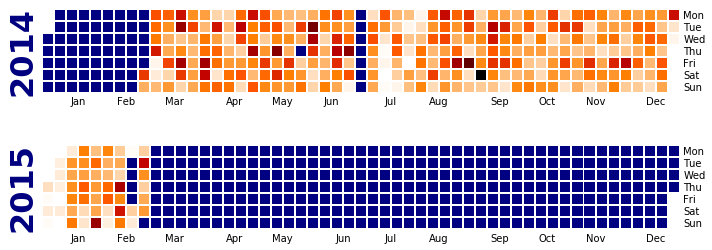

In [992]:
#Looking at heat map of user 384 for both data sets
user = 384
calmap_plot(df_use[df_use['user'].isin([user])],'ms')

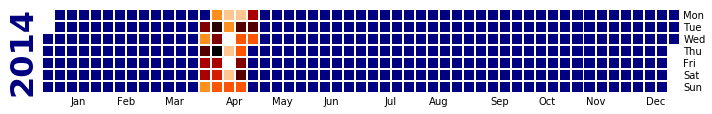

In [993]:
calmap_plot(df_loc_heat[df_loc_heat['user'].isin([user])],'ms')

### Gps locations

In [994]:
# The gps locations of the user in the interval of 3 days
df_loc_heat = df_loc_heat[(df_loc_heat['timestamp']>=1396908060000) & (df_loc_heat['timestamp']<1397167260000)][df_loc_heat['user']==user]
df_loc_label_temp = df_loc[df_loc['user']==user]
label_locations = {}
for label in df_loc_heat['label'].unique():
    label_locations[label]=[df_loc_heat[df_loc_heat['label']==label]['lat'].mean(),df_loc_heat[df_loc_heat['label']==label]['lon'].mean()]

In [995]:
gps_seq_plot = []
for i in df_loc_heat['label'].tolist():
    gps_seq_plot.append(label_locations[i])

In [996]:
lat_temp = []
lon_temp = []
for i in gps_seq_plot:
    lat_temp.append(i[0])
    lon_temp.append(i[1])
d={'lat':lat_temp,'lon':lon_temp}
pd.DataFrame(d).to_csv('gps_plot.csv')

### Phone locations

In [997]:
# Getting the nearest celltower locations of the user.
df_use_heat = df_use[(df_use['timestamp']>=1396908060000) & (df_use['timestamp']<1397167260000)]
df_use_heat = df_use_heat[df_use_heat['user']==user]
df_use_temp = df_use_heat['timestamp'].tolist()
df_cell_temp = df_cell[df_cell['user']==user]
lacs=[]
cids=[]
indexes = df_cell_temp['timestamp'].searchsorted(df_use_temp)
max_index = df_cell_temp.shape[0]
for index in range(len(indexes)):
    if abs(df_use_temp[index]-df_cell_temp['timestamp'].iloc[indexes[index]])<3600000: #Tjekker om afstanden er større end én time
        nearest_loc = df_cell_temp.iloc[indexes[index]]
        lacs.append(int(nearest_loc['lac']))
        cids.append(int(nearest_loc['cid']))
df_use_heat['lac']=lacs
df_use_heat['cid']=cids


In [998]:
# Hard coded some of the cell tower locations, instead of 
cell_dict_DK_temp = {6112:[55.69288100000001, 12.587724],6113:[55.7703728, 12.518070800000002],561:[55.787073, 12.527417999999999],1111:[55.6765548, 12.576664599999999]}
for i in range(df_use_heat.shape[0]):
    temp=df_use_heat.iloc[i][['lac','cid']].tolist()
    try:
        print str(temp[0])+"  " + str(cell_dict_DK[temp[0]][temp[1]])
    except KeyError:
        print str(temp[0]) + "fail"

6112  [[55.69288100000001, 12.587724]]
6112  [[55.69288100000001, 12.587724]]
6112  [[55.69288100000001, 12.587724]]
6113  [[55.7206188, 12.475838000000001], [55.905196999999994, 12.504538]]
6113  [[55.7206188, 12.475838000000001], [55.905196999999994, 12.504538]]
6113  [[55.7703728, 12.518070800000002], [55.77834, 12.529424]]
6113  [[55.7703728, 12.518070800000002], [55.77834, 12.529424]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.726971, 12.4765098], [55.776626, 12.525464999999999]]
6113  [[55.7703728, 12.518070800000002], [55.77834, 12.529424]]
6113  [[55.7703728, 12.518070800000002], [55.77834, 12.529424]]
6113  [[55.7703728, 12.5

In [999]:

d={user:df_use_heat['lac'].tolist()}
seq_phone_plot=location_seq(d).values()[0]
list_temp= []
for i in seq_phone_plot:
    try:
        list_temp.append(cell_dict_DK_temp[i])
    except KeyError:
        continue        

In [1000]:
lat_temp = []
lon_temp = []
for i in list_temp:
    lat_temp.append(i[0])
    lon_temp.append(i[1])
d={'lat':lat_temp,'lon':lon_temp}
pd.DataFrame(d).to_csv('phone_plot.csv')